In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

sns.set(style='ticks', context='paper', rc={'font.sans-serif':'Arial', 'pdf.fonttype': 42})

%matplotlib inline

import flotilla


flotilla_dir = '/projects/ps-yeolab/obotvinnik/flotilla_projects'

study = flotilla.embark('singlecell_pnm_figure2_modalities_bayesian', flotilla_dir=flotilla_dir)

# not_outliers = study.splicing.singles.index.difference(study.splicing.outliers.index)


/home/obotvinnik/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/obotvinnik/workspace-git/flotilla/flotilla/__init__.py:65: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  load_species_data=load_species_data)


2016-10-28 12:23:56	Reading datapackage from /projects/ps-yeolab/obotvinnik/flotilla_projects/singlecell_pnm_figure2_modalities_bayesian/datapackage.json
2016-10-28 12:23:56	Parsing datapackage to create a Study object
https://s3-us-west-2.amazonaws.com/flotilla-projects/ercc/ERCC_Controls.txt has not been downloaded before.
2016-10-28 12:24:24 	Initializing Study
2016-10-28 12:24:24 	Initializing Predictor configuration manager for Study
2016-10-28 12:24:24	Predictor ExtraTreesClassifier is of type <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>
2016-10-28 12:24:24	Added ExtraTreesClassifier to default predictors
2016-10-28 12:24:24	Predictor ExtraTreesRegressor is of type <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>
2016-10-28 12:24:24	Added ExtraTreesRegressor to default predictors
2016-10-28 12:24:24	Predictor GradientBoostingClassifier is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
2016-10-28 12:24:24	Added GradientBoostingClassi

Error loading species hg19 data: HTTP Error 404: Not Found

In [2]:
folder = 'figures/002_modality_calculation_with_outliers'
! mkdir $folder

mkdir: cannot create directory `figures/002_modality_calculation_with_outliers': File exists


## Estimate modalities

### Initialize the modality estimator

In [3]:
import anchor

bayesian = anchor.BayesianModalities()
# binned = anchor.BinnedModalities()
# monte_carlo = anchor.MonteCarloModalities()

## Calculate/Estimate modalities only on single cells, with no outliers

And at least 10 cells per splicing event, per celltype/phenotype

In [4]:
study.splicing.minimum_samples

10

In [5]:
print(study.splicing.singles.shape)
splicing_singles = study.splicing.singles.groupby(
    study.sample_id_to_phenotype).apply(lambda x: x.dropna(thresh=study.splicing.minimum_samples, axis=1))
print splicing_singles.shape

(196, 16360)
(196, 13078)


In [6]:
pkm_events = study.splicing.maybe_renamed_to_feature_id('PKM')

In [7]:
%time modality_assignments = splicing_singles.groupby(study.sample_id_to_phenotype).apply(bayesian.fit_predict)

CPU times: user 19min 53s, sys: 151 ms, total: 19min 53s
Wall time: 19min 54s


In [8]:
modality_assignments

,exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100189330-100189399:-,exon:chr10:100195392-100195529:-@exon:chr10:100195029-100195171:-@exon:chr10:100193697-100193848:-,exon:chr10:101165513-101165617:-@exon:chr10:101163481-101163631:-@exon:chr10:101163226-101163391:-,exon:chr10:101480744-101480825:-@exon:chr10:101478103-101478257:-@exon:chr10:101476105-101476218:-,exon:chr10:101507014-101507147:+@exon:chr10:101510126-101510153:+@exon:chr10:101514286-101514391:+,exon:chr10:101507014-101507147:+@exon:chr10:101514286-101514391:+@exon:chr10:101515382-101515465:+,exon:chr10:101997779-101997988:-@exon:chr10:101996607-101996726:-@exon:chr10:101995424-101995521:-,exon:chr10:102003455-102003534:-@exon:chr10:101997779-101997988:-@exon:chr10:101996607-101996726:-,exon:chr10:102013178-102013296:-@exon:chr10:102010005-102010089:-@exon:chr10:102006552-102006692:-,exon:chr10:102019975-102020076:-@exon:chr10:102016019-102016233:-@exon:chr10:102013178-102013296:-,...,exon:chrY:15560897-15560946:-@exon:chrY:15526615-15526673:-@exon:chrY:15522873-15522993:-,exon:chrY:15591134-15591384:-@exon:chrY:15582001-15582109:-@exon:chrY:15560897-15560946:-,exon:chrY:21903204-21903374:-@exon:chrY:21901414-21901548:-@exon:chrY:21897507-21897636:-,exon:chrY:21903621-21903743:-@exon:chrY:21903204-21903374:-@exon:chrY:21901414-21901548:-,exon:chrY:22744476-22744579:+@exon:chrY:22746360-22746410:+@exon:chrY:22749910-22749991:+,exon:chrY:2709527-2709668:+@exon:chrY:2710206-2710283:+@exon:chrY:2712118-2712298:+,exon:chrY:2710206-2710283:+@exon:chrY:2712118-2712298:+@exon:chrY:2713687-2713784:+,exon:chrY:2712118-2712298:+@exon:chrY:2713687-2713784:+@exon:chrY:2722641-2722812:+,exon:chrY:2713687-2713784:+@exon:chrY:2722641-2722812:+@exon:chrY:2733129-2733286:+,exon:chrY:2722641-2722812:+@exon:chrY:2733129-2733286:+@exon:chrY:2734834-2734903:+
phenotype,,,,,,,,,,,,,,,,,,,,,
MN,NaN,NaN,included,bimodal,bimodal,NaN,NaN,NaN,NaN,bimodal,...,NaN,NaN,NaN,NaN,included,included,included,included,included,included
NPC,NaN,NaN,included,bimodal,bimodal,NaN,bimodal,NaN,NaN,included,...,included,included,NaN,NaN,included,included,included,included,included,included
iPSC,bimodal,bimodal,included,included,bimodal,bimodal,included,included,bimodal,bimodal,...,included,bimodal,bimodal,bimodal,included,included,included,included,included,included


In [9]:
modalities_tidy = modality_assignments.stack().reset_index()
modalities_tidy = modalities_tidy.rename(columns={'level_1': 'event_id', 0: "modality",})
modalities_tidy.head()

,phenotype,event_id,modality
0,MN,exon:chr10:101165513-101165617:-@exon:chr10:10...,included
1,MN,exon:chr10:101480744-101480825:-@exon:chr10:10...,bimodal
2,MN,exon:chr10:101507014-101507147:+@exon:chr10:10...,bimodal
3,MN,exon:chr10:102019975-102020076:-@exon:chr10:10...,bimodal
4,MN,exon:chr10:102020723-102020801:-@exon:chr10:10...,included


In [10]:
modalities_tidy.loc[modalities_tidy.event_id.isin(pkm_events)]

,phenotype,event_id,modality
1886,MN,exon:chr15:72499069-72499221:-@exon:chr15:7249...,included
1887,MN,exon:chr15:72499069-72499221:-@exon:chr15:7249...,included
1888,MN,exon:chr15:72499069-72499221:-@exon:chr15:7249...,bimodal
1889,MN,exon:chr15:72523457-72523547:-@exon:chr15:7251...,excluded
9433,NPC,exon:chr15:72499069-72499221:-@exon:chr15:7249...,included
9434,NPC,exon:chr15:72499069-72499221:-@exon:chr15:7249...,included
9435,NPC,exon:chr15:72499069-72499221:-@exon:chr15:7249...,excluded
9436,NPC,exon:chr15:72523457-72523547:-@exon:chr15:7251...,excluded
19035,iPSC,exon:chr15:72499069-72499221:-@exon:chr15:7249...,included
19036,iPSC,exon:chr15:72499069-72499221:-@exon:chr15:7249...,excluded


In [11]:
modalities_counts = modalities_tidy.groupby(['phenotype', 'modality']).count().reset_index()
modalities_counts = modalities_counts.rename(columns={'event_id': '# AS events'})
modalities_counts.head()

,phenotype,modality,# AS events
0,MN,bimodal,1927
1,MN,excluded,1481
2,MN,included,3778
3,MN,uncategorized,2
4,NPC,bimodal,2399


In [12]:
from anchor import MODALITY_ORDER, MODALITY_PALETTE, MODALITY_TO_COLOR

In [13]:
modalities_counts_2d = modalities_counts.pivot(index='phenotype', columns='modality', values='# AS events')
modalities_counts_2d = modalities_counts_2d.reindex(columns=MODALITY_ORDER, index=study.phenotype_order)
modalities_counts_2d = modalities_counts_2d.T
modalities_counts_2d

phenotype,iPSC,NPC,MN
modality,,,
excluded,2295,1750,1481
bimodal,3447,2399,1927
included,6112,4657,3778
middle,1,NaN,NaN
uncategorized,32,4,2


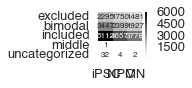

In [14]:
fig, ax= plt.subplots(figsize=(2.75, 1.5))
mask = modalities_counts_2d.isnull()
sns.heatmap(modalities_counts_2d, annot=True, mask=mask, fmt='g', annot_kws=dict(size=8), cmap='Greys')
ax.set(xlabel='', ylabel='')
fig.tight_layout()
fig.savefig('{}/modalities_counts_heatmap.pdf'.format(folder))

In [15]:
modalities_counts['percentage'] = 100*modalities_counts.groupby('phenotype')['# AS events'].apply(lambda x: x/x.sum())
modalities_counts

,phenotype,modality,# AS events,percentage
0,MN,bimodal,1927,26.808570
1,MN,excluded,1481,20.603784
2,MN,included,3778,52.559822
3,MN,uncategorized,2,0.027824
4,NPC,bimodal,2399,27.230420
5,NPC,excluded,1750,19.863791
6,NPC,included,4657,52.860386
7,NPC,uncategorized,4,0.045403
8,iPSC,bimodal,3447,28.998065
9,iPSC,excluded,2295,19.306806


## Barplots
### Split axes

/home/obotvinnik/anaconda/lib/python2.7/site-packages/seaborn/categorical.py:2848: UserWarning: The `x_order` parameter has been renamed `order`
  UserWarning)


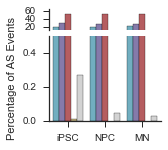

In [16]:
sns.set(style='ticks')
fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(2, 2), gridspec_kw=dict(hspace=0.1, height_ratios=[0.2, 0.8]))

ax = axes[0]
sns.barplot(x='phenotype', hue='modality', y='percentage', data=modalities_counts, ax=ax,
            hue_order=MODALITY_ORDER, palette=MODALITY_PALETTE, x_order=study.phenotype_order)
ax.legend_.set_visible(False)
ax.locator_params('y', nbins=4)
sns.despine(ax=ax, bottom=True)
ax.tick_params(axis='x', bottom='off')
ax.set(xticks=[], xlabel='', ylim=(10, 65), ylabel='') #yticks=[10, 50, ])

ax = axes[1]
sns.barplot(x='phenotype', hue='modality', y='percentage', data=modalities_counts, ax=ax,
           hue_order=MODALITY_ORDER, palette=MODALITY_PALETTE, x_order=study.phenotype_order)
ax.set(ylim=(0, 0.5), ylabel='Percentage of AS Events', 
       xlabel='')
ax.legend_.set_visible(False)
ax.locator_params('y', nbins=4)
sns.despine(ax=ax)
# fig.tight_layout()
fig.savefig('{}/modalities_barplot.pdf'.format(folder))

### Large plot with zoom

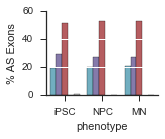

In [17]:
fig, ax = plt.subplots(figsize=(2, 1.5))

# ax = axes[0]
sns.barplot(x='phenotype', hue='modality', y='percentage', data=modalities_counts, ax=ax,
            hue_order=MODALITY_ORDER, palette=MODALITY_PALETTE, x_order=study.phenotype_order, zorder=-1)
ax.legend_.set_visible(False)
ax.locator_params('y', nbins=4)
ax.set(ylabel='% AS Exons')
ax.grid(axis='y', color='white', zorder=100)
sns.despine()
fig.savefig('{}/modalities_barplot.pdf'.format(folder))

# ax.set(ylim=(0, 0.3))
# # ax.grid(axis='y', color='grey', zorder=np.inf)
# fig.savefig('{}/modalities_barplot_zoom.pdf'.format(folder))



## Compare with the non-outlier calculation

In [18]:
non_outlier_counts = study.supplemental.modalities_tidy.groupby(['phenotype', 'modality']).size()

TypeError: You have to supply one of 'by' and 'level'